In [1]:
#input flags
iloc = int(input('I-location is '))#location of the section along i axis
jloc = 14#int(input('j-location is '))#location of the secion along j axis

variabd = 0#int(input('Enter DV flag: ')) #flag for if in variable discharge regime
adjustment_time = 65#int(input('Enter bed adjustment time here, be wary of timestep conversion: ')) #number of timesteps, in hours taken for bed to equilibrate

I-location is  850


In [2]:
# ## Import packages

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import os
import scipy.stats as stats
import seaborn as sns
import math 
import matplotlib.animation as animation
import matplotlib.colors as mcol
import matplotlib.cm as cm
import time
import random
import statistics as stat
import collections
import copy 

import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join
import PIL
from xml.dom import minidom
from shapely.geometry import Polygon, MultiPolygon

from scipy.spatial import distance
from scipy import signal
from scipy import interpolate
from scipy.stats import variation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from celluloid import Camera
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

#plt.style.use('seaborn-white')

from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap

#get_ipython().run_line_magic('matplotlib', 'inline')
#%matplotlib qt
#%matplotlib notebook



In [3]:
# ##### Setting up all the aesthetics:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 10}

mpl.rc('font', **font)
kwargs = dict(edgecolor = 'k', fc = 'xkcd:greyish', alpha=0.5, bins=20)

#—————————————————————— Set up model parameters
Q = str(100)# discharge in m3/s
slope = 0.00137#gradient
d50 = 0.31e-3 #d50 grain size in m

thot_SS = 0 # 802800
#time from which we restarted the runs to add a flood
fldstart_s = 802800 ###start time of flood in seconds

fldlength = 0
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'

datnam = f'{idf}-datamaster-{intstring}.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
arrayfolder = f'c-{idf}-{nickname}' #where raw centroid data array stored
mainsurfto = f'ms-{idf}-{nickname}' #where bounding surfaces array will go
iricoutputt =600 #output time from the model, s

datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

### More model domain set up

cellW = 4
cellL = 10
xloc = iloc*cellL
xsloc = iloc*cellL
spacing = 1 #spacing of cross stream x locations, m

ps = 2650 # bulk density of quartz kg/m3
p = 1000 # density of water in kg/m3
nu = 1.787*10e-6 #kinematic viscosity of water in m2/s
nu=1.0533e-6
g = 9.81 # acceleration due to gravity, m/s2

savefilesto = '/Volumes/SAF_Data/NAYS2DH_files/Plots/'
modelrun = f'{nickname}-{idf}-{iloc}'

gridx = 1001
gridy = 26

datacond = 1
if datacond == 1:
    cells = gridy
else:
    cells = gridx
length = 1001 #length of the domain in the x direction
erostart = 5
erostop = 5

num_timesteps = datamaster.shape[2] ##### or 168 for 2 weeks# len(os.listdir(filepathcore))-1 ###when u want to stop plotting

datamaster = datamaster[:, :, :num_timesteps]
position = np.arange(0, length, dtype = float)
coevelev = np.empty([num_timesteps])
interval_to_plot = 120/60 #we want to plot every ___  HOURS 
end_t = num_timesteps #len(np.arange(1, num_timesteps, skipstep)) #number of timesteps in data master array
fldstart = ((thot_SS+fldstart_s)/3600)/interval_to_plot ###flood starttime, s

In [4]:
##—————————————————————— Create dataframe to store data for this section
bardata = pd.DataFrame(columns=['BarName', 
                                'iloc', 
                                'PreservChar', 
                                'CoherenceVal',
                                'StartTime', 
                                'EndTime', 
                                'ElapsedTime', 
                                'LeftEdge', 
                                'RightEdge', 
                                'BarWidth', 
                                'BarHeight', 
                                'BarAspect', 
                                'BarArea', 
                                'Section Area', 
                                'ChannelProp', 
                                'Angle Skewness', 'Basal Surf Relief', 'Mean dzdx', 'Median dzdx',
                                'MinClinoHt','MaxClinoHt', 'ModeClinoHt', 'MeanClinoHt', 'SDClinoHt', 'MedClinoHt',
                                'MinClinoWt','MaxClinoWt', 'ModeClinoWt', 'MeanClinoWt', 'SDClinoWt', 'MedClinoWt',
                                'MinClinoICD','MaxClinoICD', 'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD', 'MedClinoICD',
                                'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth', 'MeanFlowDepth', 'SDFlowDepth', 'MedFlowDepth',
                                'MinShear', 'MaxShear', 'ModeShear', 'MeanShear', 'SDShear', 'MedShear',
                                'MinVelocity', 'MaxVelocity', 'ModeVelocity', 'MeanVelocity', 'SDVelocity', 'MedVelocity',
                                'process interp', 'notes'])

## define things

def ls_regression(xarr, yarr):
    ''' do a least squares regression, compute the variance between the regression and the data'''
    A = np.ones([len(xarr), 2])
    A[:, 1] = copy.deepcopy(xarr)
    y = copy.deepcopy(yarr)
    AT = np.transpose(A)
    ata = np.matmul(AT, A)
    aty = np.matmul(AT, y)
    xls1 = np.matmul(np.linalg.inv(ata), aty)
    
    x = np.linspace(A[:, 1].min(), A[:, 1].max(), len(A))
    y = xls1[1]*x + xls1[0]
    
    rms = (np.sum((y-yarr)**2)/len(yarr))**.5
    return rms, x, y

def movinggrad(stratarray, posarray):
    ##### find the moving gradient of the surfaces at 1m intervals
    ###stratarray = array with final stratigraphy, posarray = array with xposition in m
    #create gradmatrix
    
    gradmatrix = np.zeros_like(stratarray)
    angles = np.zeros_like(gradmatrix)

    for t in range (0, stratarray.shape[0]): #for each timestep in the matrix
        for x in range (0, stratarray.shape[1]-1): #for each x position, have to stop before 1 to work with array dims
           
            delta_z = (stratarray[t, x+1]-stratarray[t, x])
            delta_x = (posarray[x+1]-posarray[x])
            gradmatrix[t, x] = delta_z/delta_x
            angles[t, x] = np.degrees(np.arctan(gradmatrix[t,x]))
            #print(gradmatrix[t, x], angles[t,x])
    return gradmatrix, angles

## using cos rule to calculate bearing angles instead
## impose a limit on the y axis to create a y axis vector
def dist_between(x1, y1, x2, y2):
    d = np.sqrt((x1-x2)**2+(y1-y2)**2)
    return d

def angle_between(ax, ay, bx, by, ox = 0, oy = 0):
    
    '''find the angle between two vectors in centroid space, i.e. the trajectory'''

    ##find the lengths of all the sides of the triangle
    oa = dist_between(ox, oy, ax, ay)
    ob = dist_between(ox, oy, bx, by)
    ab = dist_between(ax, ay, bx, by)
        
    #use cosing rule to get the bearing
    cos_theta = (oa**2+ob**2-ab**2)/(2*oa*ob)
    bear = np.rad2deg(np.arccos(cos_theta))
    #if bx < ax:
    #    bear = 360-bear
    return bear

In [5]:
bardata.shape

(0, 57)

In [6]:
###—————————————————————— DATA WRANGLING

remove_ilocs = np.where(datamaster[:, 0, :] != iloc)
data = np.delete(datamaster, remove_ilocs[0], axis=0)

for i in range (0, num_timesteps):
    data[:, :, i] = data[:, :, i][np.argsort(data[:, :, i][:, 3])]

stratigraphy = np.empty([end_t, cells]) ###will hold data for topography accounting for changes due to erosion
stratigraphy_idx = stratigraphy.copy()
shearstresseroded = stratigraphy.copy() #will hold data for shear stress accounting for changes due to erosion
stratflowdepth =  stratigraphy.copy() #will hold data for flow depth accounting for changes due to erosion
scaleflowdepth =  stratigraphy.copy() #will hold data for local flow depth scaled to max accounting for changes due to erosion
froudedata =  stratigraphy.copy() #will hold data for local flow depth scaled to max accounting for changes due to erosion
velocity =  stratigraphy.copy()
runtime = len(stratigraphy)
xposition =  stratigraphy.copy()

in_section = np.where(datamaster[:, 0, -1]==iloc)
in_section = in_section[0]
bankpos = datamaster[:, 3, :][in_section]

rightbank = bankpos.min() ###negativee
leftbank = bankpos.max() #positive

xy_strat = np.empty([end_t, int(3+np.round((leftbank-rightbank)/spacing, 0))]) # will put stratigraphies here, in proper x pos
xy_strat[:] = np.nan
ages = np.empty_like(xy_strat)
#—————————————————————— Import the data
for time in range (0, data.shape[2]): #TIME
    #print(stratigraphy[time, :].shape)
    stratigraphy[time, :] = data[:, 7, time] #elevation change, elevation in 5
    shearstresseroded[time, :] = data[:, 6, time] 
    stratflowdepth[time, :] = data[:, 4, time]
    froudedata[time, :] = data[:, 9, time]
    velocity[time, :] = data[:, 10, time]
    
    ypos = data[:, 3, time]-rightbank #coreect supid centreline indexing
    
    xposition[time, :] = ypos

stratigraphy_idx = stratigraphy.copy()
shear = xy_strat.copy()
froude = xy_strat.copy()
scaleflow = xy_strat.copy() #flow depth scaled to max per time
trueflow = xy_strat.copy() #unscaled flow depth
flowvel = xy_strat.copy() #flow velocity

for t in range (0, end_t):
    for idx, x in zip(np.arange(0, stratigraphy.shape[1]), xposition[t, :]):
        x = int(np.floor(x)) #rounding down positions, making integers so can use as index
        xy_strat[t, x] = stratigraphy[t, idx]
        shear[t, x] = shearstresseroded[t, idx]
        froude[t, x] = froudedata[t, idx]
        trueflow[t, x] = stratflowdepth[t, idx]
        scaleflow[t, x] = scaleflowdepth[t, idx]
        flowvel[t, x] = velocity[t, idx]
xy_topo = np.empty_like(xy_strat)
xy_topo[:] = np.nan
for t in range (0, end_t):
    length = int(np.floor(xposition[t, -1]-xposition[t, 0])) #length of the section at time, t
    pos = np.linspace(0, length, length) #create a metre scale array with each x pos = location
    dataint = np.arange(xposition[t, 0], np.round(xposition[t, -1], 0), dtype=int)

    stratnotnan = xy_strat[t, :][~np.isnan(xy_strat[t, :])] #pull out real values of strat
    shearnotnan = shear[t, :][~np.isnan(shear[t, :])] #pull out real values of shear
    froudenotnan = froude[t, :][~np.isnan(froude[t, :])] #pull out real values of froude
    truefnotnan = trueflow[t, :][~np.isnan(trueflow[t, :])] #pull out real values of true flow depth
    velnotnan = flowvel[t, :][~np.isnan(flowvel[t, :])] #pull out real values of strat
    
    fx = interpolate.interp1d(xposition[t, :], stratnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #stratigraphy interpolation
    fsh = interpolate.interp1d(xposition[t, :], shearnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #shear stress interpolation
    ffr = interpolate.interp1d(xposition[t, :], froudenotnan[:], kind = 'cubic', fill_value = 'extrapolate') #froude number interpolation
    ftf = interpolate.interp1d(xposition[t, :], truefnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #true flow depth interpolation
    ffv = interpolate.interp1d(xposition[t, :], velnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #flow veloity interpolation
    
    xy_topo[t, dataint] = fx(dataint) #reassign strat
    shear[t, dataint] = fsh(dataint) #reassign shear
    froude[t, dataint] = ffr(dataint) #reassign froude
    trueflow[t, dataint] = ftf(dataint) #reassign true fd
    flowvel[t, dataint] = ffv(dataint) #reassign flow vel

stratcondition = np.zeros_like(xy_topo)
stratcondition[:] = np.nan
erosurf = np.empty([end_t, xy_topo.shape[1]])
erosurf[:] = np.nan
strat = copy.deepcopy(xy_topo)
halfwidth=25

for time in range (0, end_t):    
    for space in range (0, xy_topo.shape[1]):
        preexisting_strata = xy_topo[:time, :] #this is our search array, where we will erode
        willerode = np.where(preexisting_strata[:, space] > xy_topo[time, space])
        xy_topo[willerode, space] = xy_topo[time, space]
        ages[willerode, space] = time
        
for i in range (end_t-2, -1, -1):
    fillinx = np.where(np.isnan(xy_topo[i, :]))
    xy_topo[i, fillinx] = xy_topo[i+1, fillinx]
    stratcondition[i, fillinx] = 1
    fillinsh = np.where(np.isnan(shear[i, :]))
    shear[i, fillinsh] = shear[i+1, fillinsh]
    fillinfr = np.where(np.isnan(froude[i, :]))
    froude[i, fillinfr] = froude[i+1, fillinfr]
    fillintf = np.where(np.isnan(trueflow[i, :]))
    trueflow[i, fillintf] = trueflow[i+1, fillintf]
    fillinsf = np.where(np.isnan(scaleflow[i, :]))
    scaleflow[i, fillinsf] = scaleflow[i+1, fillinsf]
    fillinfv = np.where(np.isnan(flowvel[i, :]))
    flowvel[i, fillinfv] = flowvel[i+1, fillinfv]
    fillinstrat = np.where(np.isnan(strat[i, :]))

###—————————————————————— Find area of cross section
fig = plt.figure()
xs_area = plt.fill_between(np.arange(0, xy_topo.shape[1]), xy_topo[0, :], xy_topo[-1, :])
plt.close(fig)
xs_verts = xs_area.get_paths()[0].vertices
xs_polygon = Polygon(xs_verts) 
xs_bds = xs_polygon.bounds
xs_area = xs_polygon.area
xsleft = xs_bds[0]
xsbottom = xs_bds[1]
xsright = xs_bds[2]
xstop = xs_bds[3]
xs_thick = abs(np.nanmin(xy_topo[-1])-np.nanmax(xy_topo))
xs_width = xsright-xsleft

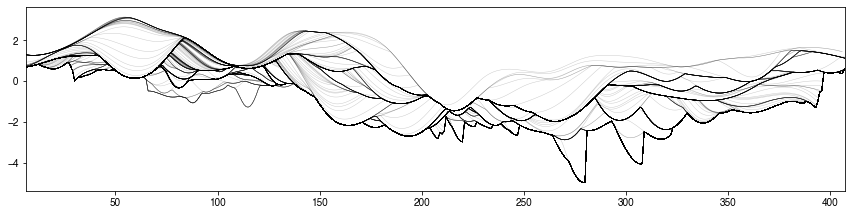

In [7]:
###—————————————————————— Get surfaces and do the rest of data wrangling for the final section to be interpreted
fig, ax = plt.subplots(figsize = (12, 3), tight_layout=True)
for i in range(0, end_t):
    ax.plot(xy_topo[i, :], 'k', alpha = 0.2, lw = 0.5)
ax.set_aspect('10')
ax.set_xlim(xposition[-1, :].min(), xposition[-1, :].max());

maxflow = np.reshape(np.nanmax(trueflow, axis=1), [end_t, 1]) ## max flow across the section at each timestep
scaleflow = trueflow/maxflow
#—————————————————————— time and x location
start_time = 0 #would be start of model run
end_time = end_t #would be end of model run
tim = range(start_time,end_time) #range of time
position = np.arange(0, xy_topo.shape[1], dtype = float)

cm1 = 'hsv'
cnorm = mcol.Normalize(vmin=min(tim),vmax=max(tim))
cpick = cm.ScalarMappable(norm=cnorm,cmap='hsv') 
cpick.set_array([])

cmap_vvfac = ListedColormap(['xkcd:mud brown', 'xkcd:shit', 'xkcd:dark tan', 'xkcd:sand', 'xkcd:stone'])
##——————————————————————facies
temp = 20.0 #temperature in degrees celcius
kv = (1.14-0.031*(temp-15)+0.00068*((temp-15)**2))*10**-6
D_star = np.power((1.65*9.81)/(1e3*(kv**2)), 0.333)*3.1e-4
d50um = 310
chezy_rough = 18*(np.log10(4*trueflow/d50)) 
mmp =(p*(flowvel**2))/(1650*(chezy_rough**2)*d50)##### modified mobility parameter
mmprange = [0.01, 0.025, 0.17, 0.35, 1.5, 10] ##### LP, R, D, D-UP, UP
norm_vvfac = BoundaryNorm(mmprange, cmap_vvfac.N)

ages_ero = np.empty_like(xy_topo)
posnew = np.arange(0, xy_topo.shape[1])

##### SCENARIO 1: Hiatus = any elevation change that is less than x cm
##### SCENARIO 2: Hiatus = any elevation change that is less than x % of the average elevation change
##### SCENARIO 3: Hiatus = any elevation change that is less than the xth percentile of change at the timestep
hiatal_scenario = 2
threshold_thick = 0.005  #absolute value in metres 
nth = 25 #what percentile distribution to use to calculate hiatal surfaces for each timestep
perc = 0.1 #fraction of percentile

for time in range (1, end_t):
    ages_ero[time, :] = time 
    lessthan = np.where(strat[time, :] < xy_topo[time-1, :]) ###where it erodes
    ele_change = strat[time, :]-xy_topo[time-1, :] #find the bed elevation change across the domain it has to be before you reassign topography else you will get zeros where replaced
    ages_ero[time, lessthan] = ages_ero[time-1, lessthan]   
    if hiatal_scenario == 1:
        threshold_thick = perc*(np.nanmean(ele_change)) #find the fraction of the average elevation change between the two latest timesteps
    if hiatal_scenario == 2:
        threshold_thick = perc*np.nanpercentile(ele_change, nth)
    if time != 0:
        hiatus_idx = np.where(abs(ele_change) < abs(threshold_thick))
        ages_ero[time, hiatus_idx] = ages_ero[time-1, hiatus_idx]
ages_ero[-1, :] = end_t
deposurf = erosurf.copy()
hiatalsurf = erosurf.copy()
erohiatalsurf = erosurf.copy()
time_of_ero = erosurf.copy()
thickness = np.zeros_like(xy_topo)

# fig, ax = plt.subplots(2, 3, figsize = (19.80, 10.8), tight_layout = True)#, sharey = True, sharex = True)#, sharex = True, sharey = True)
for time in range (1, end_t):
    thickness[time, :] = strat[time, :]-strat[time-1, :]
    thickness[time, :][np.isnan(thickness[time, :])] = 0
    if hiatal_scenario == 1:  #using a percentage of the average thickness to constrain hiatal surfaces
        threshold_thick = perc*(np.mean(thickness[time, :]))  #x% of the average sediment thickness at x time. may be negative.
    elif hiatal_scenario == 2:  #using nth percentile of the thicknesses at each timestep
        threshold_thick = perc*np.percentile(abs(thickness[time, :]), nth) #find the nth percentile of depositon at x time. positive number.

    hiatalwhere = np.where(abs(thickness[time, :]) < threshold_thick) #where elev change is less than 10% avg
    depositingwhere = np.where(thickness[time, :] > threshold_thick)
    erodingwhere = np.where(thickness[time, :] < -abs(threshold_thick))
    stratcondition[time, depositingwhere] = 0
    stratcondition[time, erodingwhere] = 1
    stratcondition[time, hiatalwhere] = 2
    erodereset = np.where(stratcondition[time, :]==1)
    erosurf[time, erodereset] = xy_topo[time, erodereset]
    deposurf[time, depositingwhere] = xy_topo[time, depositingwhere]
    hiatalsurf[time, hiatalwhere] = xy_topo[time, hiatalwhere]
    erohiatalsurf[time, erodereset] = xy_topo[time, erodereset]
    erohiatalsurf[time, hiatalwhere] = xy_topo[time, hiatalwhere]
erohiatalsurf[-1, :] = xy_topo[-1, :]

## Actually Map Bars

In [8]:
counter = 0


In [10]:
goflag = 'Y'

labelbars = plt.figure(figsize = (20, 5), tight_layout = True, dpi = 200)
fnlfig = plt.gca()

while goflag=='Y':
    #import matplotlib
    mpl.use('TkAgg')
    #%matplotlib tk

    fig = plt.figure(tight_layout=True, figsize = (20, 8))
    ax = plt.gca()

    ax.set_aspect('20')
    ax.set_facecolor('k')
    
    for strata in range (0, end_t):

        elevint = xy_topo[strata]
        vvfacies = mmp[strata] #van den berg and van gelder

        pointsint = np.array([posnew, elevint]).T.reshape(-1, 1, 2)
        segmentsint = np.concatenate([pointsint[:-1], pointsint[1:]], axis=1)

        #-------- MOBILITY WITH MMP
        vvfac = LineCollection(segmentsint, cmap = cmap_vvfac, norm = norm_vvfac)
        vvfac.set_array(vvfacies)
        vvfac.set_linewidth(1.5)
        vvfac_line = ax.add_collection(vvfac)

    for i in range (0, end_t):
        plt.plot(erohiatalsurf[i], color = cpick.to_rgba(i), lw = 1)
        # plt.plot(erohiatalsurf[i], color = 'w', lw = 1.5, alpha = 0.1)
    ticks = np.arange(0, end_t, 25)
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    # ax.colorbar(cpick,label="Time", shrink=0.3, ticks=ticks, aspect = 20, pad = 0.1, orientation = 'horizontal')

    start_time = 0 #would be start of model run
    end_time_int = num_timesteps-1 #would be end of model run

    tim_int = range(start_time,end_time) #range of time
    xdat_int = posnew #position
    ydat_int = [xy_topo[t] for t in tim_int] #stratigraphy/elevation @ position



    hmm = np.array(plt.ginput(6)) #extract 4 coordinates from the plot
    # print(hmm)
    # plt.close(fig)

    get_ipython().run_line_magic('matplotlib', 'inline')
    fakecrop = copy.deepcopy(xy_topo[:, int(hmm[0, 0]):int(hmm[1, 0])])
    # for i in range (0, num_timesteps):
        # plt.plot(fakecrop[i, :])

    if hmm.shape != (6, 2):
        print('check coordinates!!')
        break

    # st_time = np.where(np.logical_and(np.isclose(xy_topo, hmm[2, 1], atol=0.005), (np.isclose(strat, hmm[2, 1], atol=0.005))))[0][0] ##get the row index of the start time picked from the plot
    searchst = np.arange(int(hmm[2, 0])-5, int(hmm[2, 0])+5) #(2, 2)
    searchen = np.arange(int(hmm[3, 0])-5, int(hmm[3, 0])+5) #(3, 3)
    
#     basearchst = np.arange(int(hmm[4, 0])-5, int(hmm[4, 0])+5) #(2, 2)
#     basearchen = np.arange(int(hmm[5, 0])-5, int(hmm[5, 0])+5) #(3, 3)
    
    st_time = np.where(np.logical_and((np.isclose(erohiatalsurf[:, searchst], hmm[2, 1], atol=0.05)),
                                      (np.isclose(xy_topo[:, searchst], hmm[2, 1], atol=0.05))))[0][-1]
    
    # bas_st_time = np.where(np.logical_and((np.isclose(erohiatalsurf[:, basearchst], hmm[4, 1], atol=0.05)),
    #                                   (np.isclose(xy_topo[:, searchst], hmm[, 1], atol=0.05))))[0][-1]
                                      
    # np.where(np.isclose(erohiatalsurf[:, searchst], hmm[2, 1], atol=0.05)))
    # np.isclose(erohiatalsurf[:, searchen], hmm[3, 1], atol=0.05))[0][0]
    en_time = np.where(np.logical_and((np.isclose(erohiatalsurf[:, searchen], hmm[3, 1], atol=0.05)),
                                      (np.isclose(xy_topo[:, searchen], hmm[3, 1], atol=0.05))))[0][-1]
    bar_time = en_time-st_time
    #en_time = np.where(np.logical_and(np.isclose(xy_topo, hmm[3, 1], atol=0.001), (np.isclose(strat, hmm[3, 1], atol=0.001))))[0][0] ##get the row index of the start time picked from the plot
    #print(st_time)
    # print(st_time, en_time) #start and end times of bar deposition

    barleft = int(hmm[0, 0])
    barright = int(hmm[1, 0])
    bas_surf = copy.deepcopy(xy_topo[st_time, int(hmm[4, 0]):int(hmm[5, 0])]) ## basal erosion surface explicitly
    bas_length_lr = hmm[5, 0] - hmm[4, 0] ## straight line length of basal surface 
    
    
    fakecrop = fakecrop[st_time:en_time, :]
    # for i in range (0, len(fakecrop)):
        # plt.plot(fakecrop[i, :])

    pres_char = input('Enter bar preservation grade (FP, PP, TR): ')
    coher_val = input('Enter bar coherence grade: ')
    # coherence = 'co'+ input('intnernal coherence value: ')
    # aggmeasure = 'va'+ input('intnernal vertical agg value: ')
    # basalrelief = 'br'+ input('basal relief value: ')
    # barcode = f'{coherence}-{aggmeasure}-{basalrelief}'
    barID = f'{iloc}-{pres_char}-{coher_val}'
    cropped_topo = copy.deepcopy(xy_topo[st_time:en_time+1, barleft:barright+1])

    #lt.colorbar(cpick,label="Time")

    ####Pull flow depth data

    maxdep = np.nanmax(trueflow[st_time:en_time+1, :])
    depCV = stats.variation(trueflow[st_time:en_time+1, :][~np.isnan(trueflow[st_time:en_time+1, :])].ravel())


    ## Crop EVERYTHING

    ## crop the strat matrix too
    xy_topoc = copy.deepcopy(cropped_topo)
    positionc = position[barleft:barright+1]
    stratc = xy_strat[st_time:en_time+1, barleft:barright+1]
    #stratconditionc = stratcondition[st_time:en_time+1, barleft:barright+1]

    end_tc = len(xy_topoc)
    num_timestepsc = end_tc

    shearc = shear[st_time:en_time+1, barleft:barright+1]
    scaleflowc = scaleflow[st_time:en_time+1, barleft:barright+1]
    trueflowc = trueflow[st_time:en_time+1, barleft:barright+1]
    flowvelc = flowvel[st_time:en_time+1, barleft:barright+1]
    ehsurfc = erohiatalsurf[st_time:en_time+1, barleft:barright+1]

    #=============MAKE MASTER ARRAY FOR BAR PKG, EXPORT============================
    if not os.path.exists(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/Summer-bpkg-redo/{iloc}'):
        os.makedirs(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/Summer-bpkg-redo/{iloc}')

    masterarr = np.concatenate((np.expand_dims(xy_topoc, 2), 
                                np.expand_dims(ehsurfc, 2), 
                                np.expand_dims(shearc, 2),
                                np.expand_dims(trueflowc, 2),
                                np.expand_dims(flowvelc, 2)), axis=2)
    np.save(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/Summer-bpkg-redo/{iloc}/{barID}-{counter}', masterarr, allow_pickle=True)

    ####————————————————— EXTRACT FLOW DEPTH STATISTICS—————————————————————————————
    max_depth= np.nanmax(trueflowc)
    min_depth = np.nanmin(trueflowc)
    mean_depth = np.nanmean(trueflowc)
    stddev_depth = np.nanstd(trueflowc)
    mod_depth = float(stats.mode(trueflowc, nan_policy = 'omit')[0][0][0])
    med_depth = np.nanmedian(trueflowc)

    ####————————————————— EXTRACT SHEAR STRESS STATISTICS—————————————————————————————
    max_shear= np.nanmax(shearc)
    min_shear = np.nanmin(shearc)
    mean_shear = np.nanmean(shearc)
    stddev_shear = np.nanstd(shearc)
    mod_shear = float(stats.mode(shearc, nan_policy = 'omit')[0][0][0])
    med_shear = np.nanmedian(shearc)

    ####————————————————— EXTRACT FLOW VELOCITY STATISTICS—————————————————————————————
    max_vel= np.nanmax(flowvelc)
    min_vel = np.nanmin(flowvelc)
    mean_vel = np.nanmean(flowvelc)
    stddev_vel = np.nanstd(flowvelc)
    mod_vel = float(stats.mode(flowvelc, nan_policy = 'omit')[0][0][0])
    med_vel = np.nanmedian(flowvelc)

    ####————————————————— EXTRACT SLOPE for COHERENCE STATISTICS—————————————————————————————
    slopes, coher_angles = movinggrad(xy_topoc, positionc)
    ##————————————––––––––––––––––––––––––––––––GET BAR PACKAGE DIMENSIONS————————————––––––––––––––––––––––––
    fig=plt.figure()
    fullbar = plt.fill_between(posnew[barleft:barright+1], xy_topoc[0], xy_topoc[-1])
    plt.close(fig)

    barverts = fullbar.get_paths()[0].vertices
    bar_polygon = Polygon(barverts) 
    bds = bar_polygon.bounds
    bar_area = bar_polygon.area
    left = bds[0]
    bottom = bds[1]
    right = bds[2]
    top = bds[3]
    bar_height = abs(np.nanmin(xy_topoc)-np.nanmax(xy_topoc))
    bar_width = right-left
    bar_w_to_h = bar_width/bar_height
    prop_area = bar_area/xs_area

    bas_surf_relief = np.nanmax(bas_surf)-np.nanmin(bas_surf)
    br_scale = bas_surf_relief/bar_height
    
    ###==================================GET CENTROIDS AND INTERNAL STATS==================================

    nan_border = np.empty([end_tc, 1])
    nan_border.shape
    nan_border[:] = np.nan
    #topointerp_nb = np.concatenate((nan_border, strat, nan_border), axis = 1) #nb = nan border
    stratinterpcub_nb = np.concatenate((nan_border, xy_topoc, nan_border), axis = 1)

    posnewc = np.arange(0, xy_topoc.shape[1], dtype = float)
    posnewc_nb = np.insert(posnewc, [0], [np.nan])
    posnewc_nb = np.insert(posnewc_nb, -1, np.nan)

    SIC_startcrop = copy.deepcopy(xy_topoc)
    SIC_startcrop = np.concatenate((nan_border, SIC_startcrop, nan_border), axis = 1)

    SIC_startcrop = np.delete(SIC_startcrop, 0, axis = 0)
    SIC_startcrop.shape

    SIC_endcrop = copy.deepcopy(xy_topoc)
    SIC_endcrop = np.concatenate((nan_border, SIC_endcrop, nan_border), axis = 1)

    SIC_endcrop = np.delete(SIC_endcrop, -1, axis=0)
    SIC_endcrop.shape

    delta = SIC_startcrop-SIC_endcrop

    delta[np.where(delta[:]==0)] = np.nan

    #print(len(posnewc_nb))
    #l_edges = np.empty([1,]) #left edge distance measure of the wheeler fill
    l_idx = np.empty([1,]) #index value of left edge
    #r_edges = np.empty([1,]) #right edge of the wheeler fill
    r_idx = np.empty([1,]) #index value of right edge
    surf_age = np.empty([1,]) #age of each deposit for the wheeler diagram
    for i in range (0, len(delta)):
        #if ~np.isnan(deposurf[i, 0]):
        #   rectangles[i, 0] = ages[i, 0] #if the left edge of the stratigraphy is a depositional surface

        for xpos in range (0, len(posnewc_nb)-1):
            l_edge = np.all((np.isnan(delta[i, xpos]) and ~np.isnan(delta[i, xpos+1])))
            r_edge = np.all((~np.isnan(delta[i, xpos]) and np.isnan(delta[i, xpos+1])))
            #print(xpos, 'L', l_edge)
            #print(xpos, 'R', r_edge)
            if l_edge == True:
                #l_edges = np.append(l_edges, [posnewc_nb[xpos+1]], axis = 0)
                l_idx = np.append(l_idx, [xpos], axis = 0)
                #print(posnewc_nb[xpos+1], 'potato')
                surf_age = np.append(surf_age, [i], axis = 0)
            if r_edge == True:
                #print(xpos, 'tomato')
                #r_edges = np.append(r_edges, [posnewc_nb[xpos-1]], axis = 0)
                r_idx = np.append(r_idx, [xpos], axis = 0)


    # Store all those vertices in an array that houses the time of each polygon and the left and right edges of the poly

    l_idx = np.reshape(l_idx, [len(l_idx), 1])
    #l_index = np.delete(l_index, 1)

    l_idx = l_idx.astype(int)
    r_idx = np.reshape(r_idx, [len(r_idx), 1])
    #r_index = np.delete(r_index, 1)
    r_idx = r_idx.astype(int)

    #print(l_idx[:, 0], r_idx[:, 0])
    surf_age = np.reshape(surf_age, [len(surf_age), 1])

    # print(l_idx.shape, r_idx.shape, surf_age.shape)

    vertices_b = surf_age
    vertices_b = np.append(vertices_b, l_idx, axis = 1)
    vertices_b = np.append(vertices_b, r_idx, axis = 1)

    #print(vertices)#, vertices.shape)


    cent_array = np.empty([len(vertices_b), 8])
    cent_array[:] = np.nan
    cent_mass = np.empty([len(vertices_b), 2]) ##store the centre of mass of the polygons
    # print(cent_mass.shape)

    ## Plot the filled stratigraphy, create a polygon for each, find the centroid, store the centroid and its age
    testfig, ax1 = plt.subplots(1, 1, tight_layout=True, squeeze=True, figsize = (10,6))
    poly_data = {}
    for i in range (1, len(vertices_b)):
        time = int(vertices_b[i, 0])
        left = int(vertices_b[i, 1])
        right = int(vertices_b[i, 2])

        poly = ax1.fill_between(posnewc[left:right], xy_topoc[time, left:right], xy_topoc[time+1, left:right], color=cpick.to_rgba(i))
        pverts = poly.get_paths()[0].vertices

        polygon = Polygon(pverts) #create a shapely polygon
        #print(polygon)
        poly_data[i] = polygon
        area = polygon.area
        bounds = polygon.bounds
        #print(type(bounds[0]))
        cent_array[i, 4] = bounds[0]
        cent_array[i, 5] = bounds[1]
        cent_array[i, 6] = bounds[2]
        cent_array[i, 7] = bounds[3]
        cent_array[i, 3] = area
        ctroid = polygon.centroid
        cent_array[i, 0] = time
        cent_array[i, 1] = ctroid.x
        cent_array[i, 2] = ctroid.y

    ptile10 = 1 ## setting an actual threshold bc some of these are still too small


    cent_wnan = copy.deepcopy(cent_array)
    deletewhere = np.where(cent_array[:, 3] < ptile10)
    cent_wnan[deletewhere] = np.nan

    cent_nonan = cent_wnan[~np.isnan(cent_wnan).any(axis = 1)] #delete all rows in cent_wnan matrix with nan values

    poly_widths = cent_nonan[:, 6]-cent_nonan[:, 4]
    poly_widths = np.reshape(poly_widths, [len(poly_widths), 1])

    poly_heights = cent_nonan[:, 7]-cent_nonan[:, 5]
    poly_heights = np.reshape(poly_heights, [len(poly_heights), 1])

    cent_nonan = np.concatenate((cent_nonan, poly_widths, poly_heights), axis = 1)

    range_x = position.max()-position.min()
    range_y = np.nanmax(xy_topoc)-np.nanmin(xy_topoc)
    # print(range_x, range_y)

    dists = np.zeros([len(cent_nonan[:, 3]), 1])
    reltime = np.zeros([len(cent_nonan[:, 3]), 1]) #will store the elapsed time between two consecutive centroids
    delx = np.zeros([len(cent_nonan[:, 3]), 1])
    dely = np.zeros([len(cent_nonan[:, 3]), 1])

    for i in range (0, len(cent_nonan)-1):
        dists[i, 0] = ((cent_nonan[i+1, 1]-cent_nonan[i, 1])**2+(cent_nonan[i+1, 2]-cent_nonan[i, 2])**2)**0.5
        reltime[i,0] = cent_nonan[i+1, 0]-cent_nonan[i, 0]
        delx[i, 0] = abs(cent_nonan[i+1, 1]-cent_nonan[i, 1])/range_x
        dely[i, 0] = abs(cent_nonan[i+1, 2]-cent_nonan[i, 2])/range_y
    cent_nonan = np.concatenate((cent_nonan, dists, reltime, delx, dely), axis = 1)


    delx = np.delete(delx, -1, axis=0)
    dely = np.delete(dely, -1, axis=0)

    # slopes, coher_angles = movinggrad(xy_topoc, positionc)
    skewness = stats.skew(coher_angles.ravel())
    ve_10x = ((cent_nonan[1:, 2]-cent_nonan[:-1, 2])*10)/(cent_nonan[1:, 1]-cent_nonan[:-1, 1])
    mean_ve_10x = np.average(ve_10x)
    med_ve_10x = np.median(ve_10x)
    ####————————————————— EXTRACT CLINO STATISTICS—————————————————————————————
    mod_ht =float(stats.mode(poly_heights)[0])
    med_ht = np.median(poly_heights)
    mean_ht = np.mean(poly_heights)
    max_ht = np.max(poly_heights)
    min_ht = np.min(poly_heights)
    stddev_ht = np.std(poly_heights)

    ## Widths
    mod_wt = float(stats.mode(poly_widths)[0])
    med_wt = np.median(poly_widths)
    mean_wt = np.mean(poly_widths)
    max_wt = np.max(poly_widths)
    min_wt = np.min(poly_widths)
    stddev_wt = np.std(poly_widths)

    ## ICDs
    mod_icd =float(stats.mode(dists)[0])
    med_icd = np.median(dists)
    mean_icd = np.mean(dists)
    max_icd = np.max(dists)
    min_icd = np.min(dists)
    stddev_icd = np.std(dists)

    ###--------------------Relating clinos to full bar--------------------------------

    packages_rel_to_bar_height = cent_nonan[:, 9]/bar_height
    prop_of_xs_is_bar = bar_area/xs_polygon.area 

    process = input('process interp: ')
    note = input('any notes? ')
    plt.close()

    pkgdata = pd.DataFrame([(barID, 
                             iloc,
                             pres_char, 
                             coher_val, 
                             st_time,
                             en_time, 
                             bar_time, 
                             barleft, 
                             barright, 
                            bar_width, bar_height, bar_w_to_h, bar_area, xs_area, prop_area,
                            skewness, bas_surf_relief, mean_ve_10x, med_ve_10x,
                            min_ht, max_ht, mod_ht, mean_ht, stddev_ht, med_ht,
                            min_wt, max_wt, mod_wt, mean_wt, stddev_wt, med_wt,
                            min_icd, max_icd, mod_icd, mean_icd, stddev_icd, med_icd,
                            min_depth, max_depth, mod_depth, mean_depth, stddev_depth, med_depth, 
                            min_shear, max_shear, mod_shear, mean_shear, stddev_shear, med_shear, 
                            min_vel, max_vel, mod_vel, mean_vel, stddev_vel, med_vel, process, note)],

                           columns=['BarName', 
                                'iloc', 
                                'PreservChar', 
                                'CoherenceVal',
                                'StartTime', 
                                'EndTime', 
                                'ElapsedTime', 
                                'LeftEdge', 
                                'RightEdge', 
                                'BarWidth', 
                                'BarHeight', 
                                'BarAspect', 
                                'BarArea', 
                                'Section Area', 
                                'ChannelProp', 
                                'Angle Skewness', 'Basal Surf Relief', 'Mean dzdx', 'Median dzdx',
                                'MinClinoHt','MaxClinoHt', 'ModeClinoHt', 'MeanClinoHt', 'SDClinoHt', 'MedClinoHt',
                                'MinClinoWt','MaxClinoWt', 'ModeClinoWt', 'MeanClinoWt', 'SDClinoWt', 'MedClinoWt',
                                'MinClinoICD','MaxClinoICD', 'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD', 'MedClinoICD',
                                'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth', 'MeanFlowDepth', 'SDFlowDepth', 'MedFlowDepth',
                                'MinShear', 'MaxShear', 'ModeShear', 'MeanShear', 'SDShear', 'MedShear',
                                'MinVelocity', 'MaxVelocity', 'ModeVelocity', 'MeanVelocity', 'SDVelocity', 'MedVelocity',
                                'process interp', 'notes'])
    bardata = pd.concat([bardata, pkgdata], axis = 0, ignore_index = True)
    ## final bar plot
    plt.plot(bas_surf)
    counter = counter + 1 
    goflag = input('Go flag: ')
    
    x, y = bar_polygon.exterior.xy
    fnlfig.plot(x, y, label = barID)
#fnlfig.legend()
    
bardata.to_csv(f'/Volumes/SAF_Data/NAYS2DH_files/Data/barCSVs/Sp2022/Summer-redo/{iloc}.csv')

# In[59]:


bardata


# In[ ]:



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [11]:
bas_surf_relief = bas_surf.max()-bas_surf.min()
br_scale = bas_surf_relief/bar_height

In [12]:
br_scale

1.0129599251854167

In [ ]:
### time series of surface variance
variancess = np.var(xy_topoc, where = ~np.isnan(xy_topoc), axis = 1)

plt.plot(variancess)
plt.ylabel('Variance')
plt.xlabel('Timestep')

In [ ]:
plt.figure(figsize = (50, 4))
plt.plot(bas_surf)
# plt.plot(xy_topoc[-8, :])
# plt.plot(xy_topoc[-6, :])
# plt.plot(xy_topoc[-4, :])
plt.axhline(np.nanmean(bas_surf))
cvbase =stats.variation(bas_surf, nan_policy = 'omit')
plt.title(f'Variance = {np.var(bas_surf)}, CV = {cvbase}')
ax = plt.gca()
ax.set_aspect('equal')

In [ ]:
for i in range(0, len(xy_topoc)):
    plt.plot(xy_topoc[i])
plt.plot(cent_array[:, 1], cent_array[:, 2], lw = 0, marker = '.')
plt.plot(ls_regression(cent_nonan[:, 1], cent_nonan[:, 2])[1], ls_regression(cent_nonan[:, 1], cent_nonan[:, 2])[2])
plt.title(f'RMS of centroid regression = {ls_regression(cent_nonan[:, 1], cent_nonan[:, 2])[0]}')


In [ ]:
vert_growth = cent_nonan[1:, 2]-cent_nonan[:-1, 2]

In [ ]:
# xs_thick = abs(np.nanmin(xy_topo[-1])-np.nanmax(xy_topo))
plt.plot(vert_growth/xs_thick)
plt.axhline(np.mean(vert_growth))
plt.title('thickness change between centroids/section thickness')

In [ ]:
slopes, coher_angles = movinggrad(xy_topoc, positionc)
# coh_offset = coher_angles-np.mean(coher_angles) ##distance from the mean angle i cant remember the statistical name for this

# sns.histplot(coher_angles.ravel(), kde=True, bins = 9, bin_range = (0, 90))
#sns.histplot(x=coher_angles.ravel(), y=coh_offset.ravel())
# sns.histplot(coh_offset.ravel(), bins = 10)
sns.histplot(coher_angles.ravel(), bins = 10, element = 'step', fill=False, legend=False, kde = False)
plt.title('Distribution of surface slope/dip angles')

In [ ]:
fig, ax = plt.subplots(1, tight_layout = True, figsize = (10, 6))
cmap_dip = ListedColormap(['xkcd:red', 'xkcd:orange', 'xkcd:baby blue', 'xkcd:taupe', 'xkcd:taupe', 'xkcd:baby blue', 'xkcd:orange', 'xkcd:red'])
norm_dip = BoundaryNorm([-30, -20, -5, -2, 0, 2, 5, 20, 30], cmap_dip.N)
# cmap_dip = ListedColormap(['xkcd:red', 'xkcd:orange', 'xkcd:baby blue', 'xkcd:taupe'])
# norm_dip = BoundaryNorm([-30, -20, -5, -2, 0], cmap_dip.N)

for t in range (0, len(xy_topoc)):
    #slope = strat_gradient[t]
    dip = coher_angles[t]
    zdata = xy_topoc[t]
    
    points = np.array([positionc, zdata]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # slopenorm = plt.Normalize(np.nanmin(strat_gradient), np.nanmax(strat_gradient))
    dipnorm = plt.Normalize(np.nanmin(coher_angles), 0)
    
    slopelc = LineCollection(segments, cmap = cmap_dip, norm = norm_dip)
    slopelc.set_array(dip)
    slopelc.set_linewidth(2)
    slopeline = ax.add_collection(slopelc)

ax.set_facecolor('xkcd:midnight blue')    
ax.set_xlim(positionc.min(), positionc.max());
ax.set_ylim(np.nanmin(xy_topoc), np.nanmax(xy_topoc));
ax.set_aspect(20)
cbar = fig.colorbar(slopeline, label='dip angles', ax=ax, shrink = 0.6, pad = 0.01, aspect = 10)
cbar.ax.tick_params(labelsize=6) 

meanang = np.mean(coher_angles)
sd_ang = np.std(coher_angles)
cv_ang = stats.variation(coher_angles.ravel())
print(sd_ang, cv_ang, meanang)

In [ ]:
sns.histplot(coher_angles.ravel(), bins = [-30, -20, -5, -2, 0, 2, 5, 20, 30], element = 'step', fill=False, legend=False, kde = False)
plt.title('Distribution of surface slope/dip angles')

In [ ]:
np.median(coher_angles)

nbins = np.deg2rad(np.arange(0, 361, 1)) #10° bins
rad_bearings = np.deg2rad(coher_angles) #these are fine, exactly the same as the degree version, duh
bearing_radii, bearing_edges = np.histogram(rad_bearings, bins = nbins, density=False)
bearing_centres = bearing_edges[:-1]+0.5*(bearing_edges[1]-bearing_edges[0])
# print(bearing_radii)
wedge_width = ((2*np.pi)/len(nbins))*np.ones(len(bearing_centres)) #10°, this is also fine. 


# rad_ang_between = np.deg2rad(ang_between)
# ab_radii, ab_edges = np.histogram(rad_ang_between, bins = nbins, range= (0, 2*np.pi))
# ab_centres = ab_edges[:-1]+0.5*(ab_edges[1]-ab_edges[0])

# mean_bearing = np.average(coher_angles)
# variance = abs(coher_angles-mean_bearing)

# rad_variance = np.deg2rad(variance)
# var_radii, var_edges = np.histogram(rad_variance, bins = nbins, range= (0, 2*np.pi))
# var_centres = var_edges[:-1]+0.5*(var_edges[1]-var_edges[0])
# print(var_radii)
fig = plt.figure(figsize=(4, 4))


ax = fig.add_subplot(projection='polar')

# ax1 = fig.add_subplot(projection='polar')


ax.set_theta_zero_location('N')

ax.set_theta_direction(-1)

ax.bar(bearing_centres, bearing_radii, width = wedge_width, bottom=0)
# ax2.bar(var_centres, var_radii, width = wedge_width, bottom=0)


In [ ]:
sns.histplot((delx/dely).ravel())

In [ ]:
plt.figure(figsize = (20, 4))
plt.plot(positionc, coher_angles[50, :], lw = 0, marker = 'o')
plt.plot(positionc, xy_topoc[50, :], marker = '+')

In [ ]:
sns.histplot(dely/med_depth)
sns.histplot(dely/max_depth, element = 'step', fill=False)
plt.title('Vert agg metric? dely/med_depth, ins max')

In [ ]:
va_ratio = dely/med_depth
sns.histplot(dely/med_depth, kde = True, label = 'VA_ratio')
ptiles = np.quantile(va_ratio, [0.5, .75, .9])
plt.axvline(ptiles[0], label = '50th', color = 'r')
plt.axvline(ptiles[1], label = '75th', color = 'g')
plt.axvline(ptiles[2], label = '90th', color = 'b')
plt.legend()
plt.title('VA Ratio and some percentiles')

In [ ]:
meanang = np.mean(coher_angles)
sd_ang = np.std(coher_angles)
cv_ang = stats.variation(coher_angles.ravel())
print(sd_ang, cv_ang, meanang)

In [ ]:
ang_between = np.empty(len(cent_nonan)-1)
for i in range(0, len(cent_nonan)-2):
    #print('a',cent_nonan[i, 1:3])
    #print('b', cent_nonan[i+1, 1:3])
    ax, ay, bx, by = cent_nonan[i:i+2, 1:3].ravel()
    #print(ax, ay, bx, by)
    ang_between[i] = angle_between(ax, ay, bx, by)  

In [ ]:
sns.histplot(ang_between)

In [ ]:
print('Skewness: ', stats.skew(coher_angles.ravel()))
print('Basal relief: ', bas_surf_relief)
sns.histplot(ve_10x.ravel())